In [1]:
# Imports and config

import warnings
from glob import glob
from pathlib import Path

import astropy.constants as constants
import astropy.units as u
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from lvm_lib.config.data_config import DataConfig
from lvm_lib.data.tile import LVMTile, LVMTileCollection
from lvm_lib.fit_data.builder import FitDataBuilder
from lvm_lib.fit_data.filtering import BAD_FLUX_THRESHOLD
from model import ConstrainedGaussian
from modelling_lib import (
    Constant,
    ConstrainedParameter,
    FourierGP,
    Kernel,
    Matern12,
    Matern32,
    OptimiserFrame,
    Parameter,
    PerSpaxel,
    SpatialData,
    SpectralSpatialModel,
    build_model,
)
from numpy.random import default_rng
from optax import adam, lbfgs
from plots_lib import COLORS

rng = default_rng(0)
jax.config.update("jax_enable_x64", True)
plt.style.use("plots_lib.custom")
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

# Example 2: ${\rm HeI}$ 4471 in Rosette

## Intro

Let's try now the HeI 4471 recombination line in Rosette. In the DAP this line is analysed with a weighted-moment analysis due to its low S/N in the data, rather than the parametric model used for stronger lines.

We'll fit essentially the exact sample model as we did for ${\rm H \alpha}$, so I won't go over the model details again and just point out any differences.

In [2]:
class LVMModel(SpectralSpatialModel):
    # Model components
    continuum: Constant  # not really meant to model the continuum since it's mostly for nuisance but it's like continuum *shrug*
    line: ConstrainedGaussian  # "Constrained" just means the amplitude and width are >0

    def __init__(
        self,
        n_spaxels: int,
        n_modes: tuple[int, int],
        A_kernel: Kernel,
        λ0_kernel: Kernel,
        lsf: Parameter,
        offsets: Parameter,
    ):
        # Build the constant per-spaxel component
        self.continuum = Constant(
            const=PerSpaxel(
                n_spaxels=n_spaxels,
                spaxel_values=offsets,
            ),
        )
        # Build the emission line component
        self.line = ConstrainedGaussian(
            A=FourierGP(n_modes, A_kernel),
            λ0=FourierGP(n_modes, λ0_kernel),
            σ=PerSpaxel(n_spaxels, lsf),
        )

    # Instructions for evaluating the model
    def __call__(self, λ, spatial_data):
        return self.continuum(λ, spatial_data) + self.line(λ, spatial_data)

## Data reading

This time we'll only use the centre-most 7 tiles.

In [3]:
LINE_CENTRE = 5755  # recombination line centre in Angstroms


# drp_files = glob("../../data/rosette/lvm*.fits")
loc = Path("../../data/rosette/")
drp_files = [
    loc / "lvmSFrame-00030873.fits",  # inner
    loc / "lvmSFrame-00030874.fits",  # inner
    loc / "lvmSFrame-00030926.fits",  # inner
    loc / "lvmSFrame-00030928.fits",  # inner
    loc / "lvmSFrame-00030816.fits",  # inner
    loc / "lvmSFrame-00030818.fits",  # inner
    loc / "lvmSFrame-00030871.fits",  # inner
    # loc / "lvmSFrame-00030207.fits",  # outer
    # loc / "lvmSFrame-00030875.fits",  # outer
    # loc / "lvmSFrame-00030761.fits",  # outer
    # loc / "lvmSFrame-00030925.fits",  # outer
    # loc / "lvmSFrame-00030763.fits",  # outer
    # loc / "lvmSFrame-00030764.fits",  # outer
    # loc / "lvmSFrame-00030929.fits",  # outer
    # loc / "lvmSFrame-00030817.fits",  # outer
    # loc / "lvmSFrame-00031089.fits",  # outer
    # loc / "lvmSFrame-00031091.fits",  # outer
    # loc / "lvmSFrame-00030819.fits",  # outer
    # loc / "lvmSFrame-00031092.fits",  # outer
]
λ_range = (LINE_CENTRE - 8, LINE_CENTRE + 8)

# Some nice objects for loading the data
tiles = LVMTileCollection.from_tiles([LVMTile.from_file(Path(f)) for f in drp_files])
# This config object lazily loads the data (for when things get big) and applyies some trimming/filtering as well as normalisation/scaling to help the fitting
# The data is loaded to memory temporarily for the sake of calculating scaling factors
config = DataConfig.from_tiles(
    tiles,
    λ_range,
    normalise_F_scale=1e-12,
    normalise_F_offset=-1e-14,
    F_range=(BAD_FLUX_THRESHOLD, 1e-14),
)
# F_range filters out spaxels where the median is very negative (bad sky subtraction) or very positive (stellar contamination)

# Convert the data into a nice form for the model
builder = FitDataBuilder(tiles, config)  # This can provide a hash for perfect reproducability
fd = builder.build()  # fd contains all the stuff we need for fitting, lazily loaded to ease memory use until we actually do optimisation

Plotting the data again. This time we'll use the max flux value in the spectral direction instead of the sum.

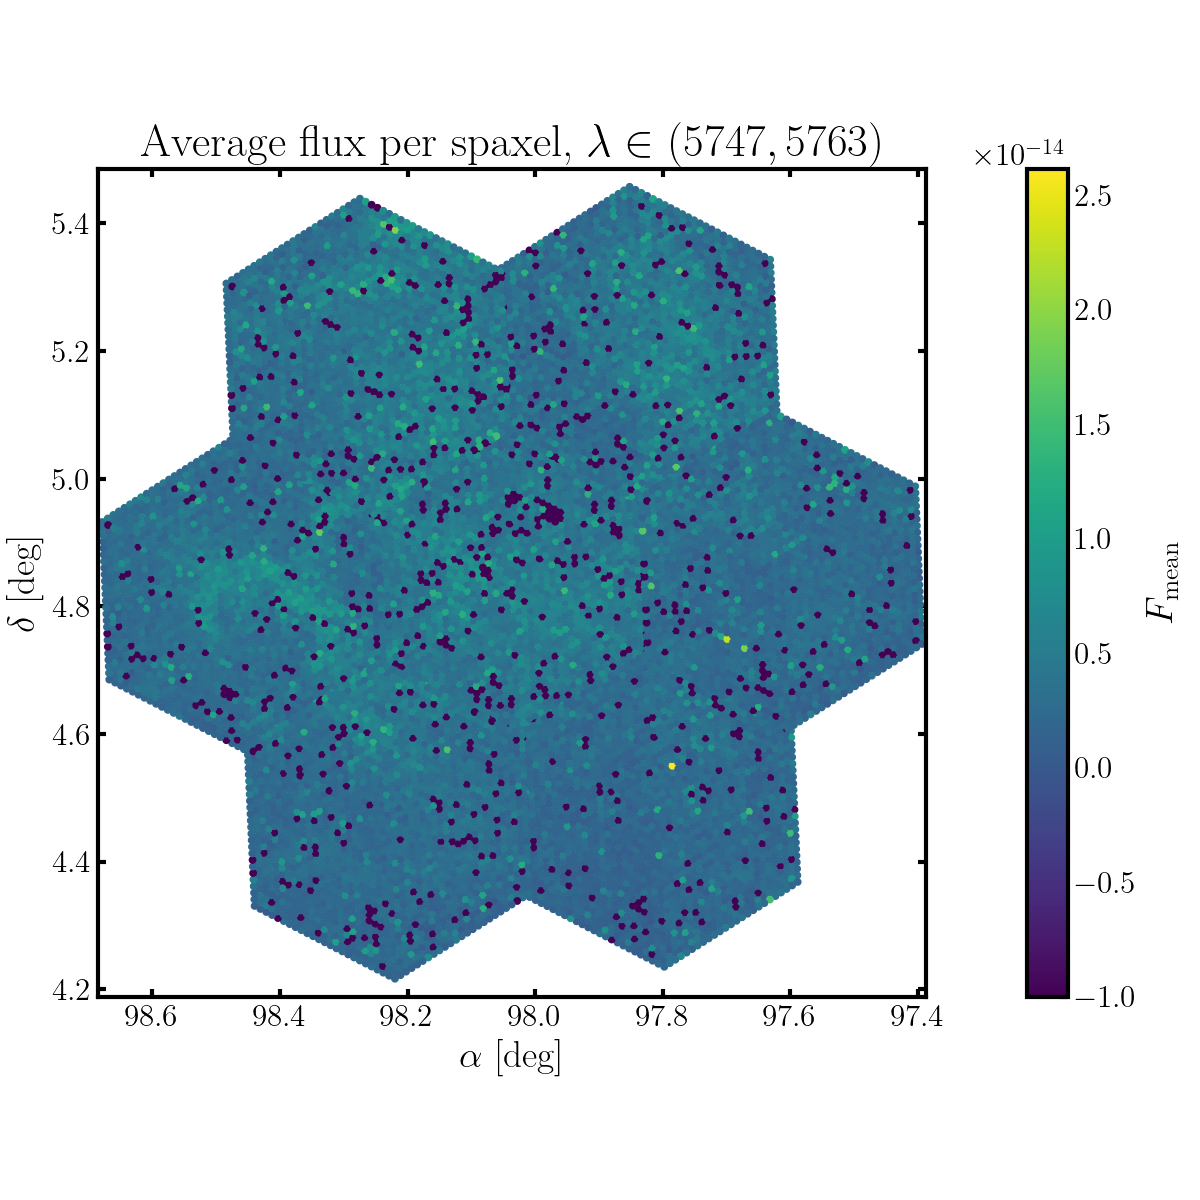

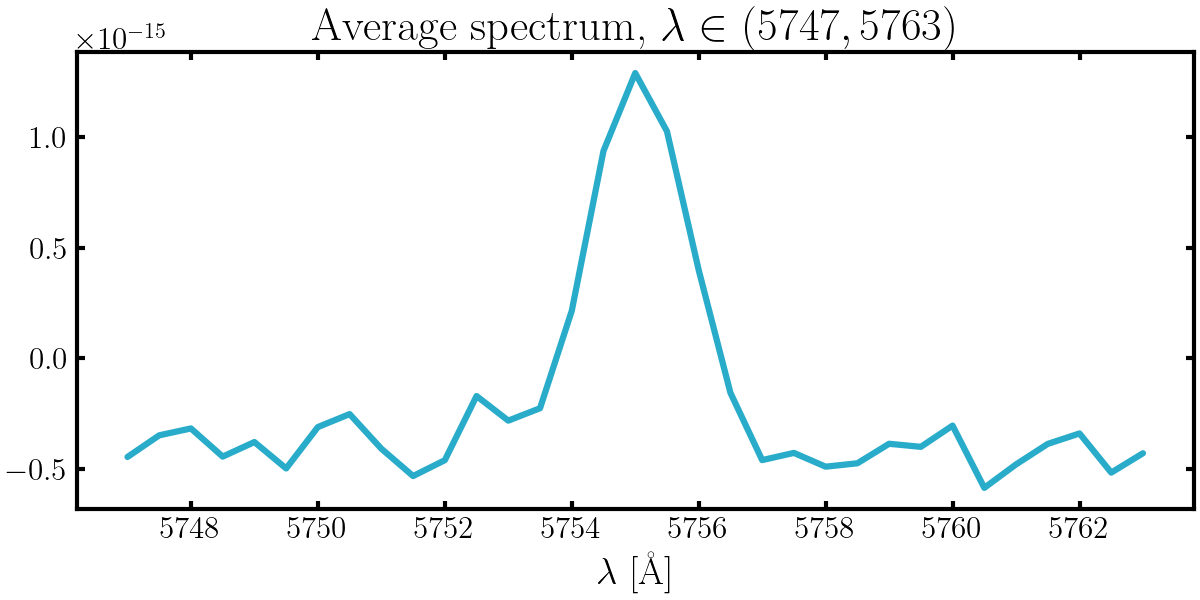

In [4]:
fig, ax = plt.subplots(figsize=[8, 8], layout="compressed", dpi=150)
ax.set_title(rf"Average flux per spaxel, $\lambda \in {λ_range}$")
# the "predict_x" functions unscale the coordinates to how they were originally for plotting or for comparison once we have model predictions
cs = ax.scatter(
    fd.predict_α(fd.α), fd.predict_δ(fd.δ), c=np.nanmax(fd.predict_flux(fd.flux), axis=0), s=5
)
plt.colorbar(cs, ax=ax, label=r"$F_{\rm mean}$")
ax.set_aspect(1)
ax.set_xlabel(r"$\alpha$ [deg]")
ax.set_ylabel(r"$\delta$ [deg]")
ax.set_xlim(config.α_range[1], config.α_range[0])
ax.set_ylim(*config.δ_range)
plt.show()

fig, ax = plt.subplots(figsize=[8, 4], layout="compressed", dpi=150)
ax.set_title(rf"Average spectrum, $\lambda \in {λ_range}$")
ax.plot(fd.λ, np.nanmean(fd.predict_flux(fd.flux), axis=1))
ax.set_xlabel(r"$\lambda$ [${\rm \AA}$]")
plt.show()

So, we can see some stuff in the top plot, but it's very low S/N. If I make a plot as in the previous notebook where I sum the flux, we see just noise. The line is clearly present though, as we can see in the combined spectrum in the bottom plot.

In [5]:
# fd._flux has the bad data as nans. fd.flux replaces them with zeros so jax doesn't die
n_bad_spax = np.sum(np.all(np.isnan(fd._flux), axis=0))
n_bad_pix = np.sum(np.isnan(fd._flux))

print(f"no. missing spaxels = {n_bad_spax} / {len(fd.α)}")
print(f"no. missing pixels = {n_bad_pix} / {fd.flux.size}")

no. missing spaxels = 807 / 12607
no. missing pixels = 26694 / 416031


## Build the model

The model setup here is the same except that we initialise the variance on the line flux A as lower (because the line is weaker and I didn't change the normalisation/scaling), and we place a lower upper bound on the variance on the line widths σ. We also choose fewer modes.

In [6]:
n_modes = (51, 51)
n_spaxels = len(fd.α)

# We give also some sensible initial guesses to help optimisation, and some bounds which mostly just enforce positivity
fix_kp = False
shared_length_scale = ConstrainedParameter(initial=1.0, fixed=fix_kp, lower=0.01, upper=5)
# σ_length_scale = ConstrainedParameter(initial=0.6, fixed=fix_kp, lower=0.1, upper=5)
# It seems to help to start the line as too bright rather than too faint
A_variance = ConstrainedParameter(initial=1e-2, fixed=fix_kp, lower=1e-5, upper=5)
λ0_variance = ConstrainedParameter(initial=1e-4, fixed=fix_kp, lower=1e-5, upper=5)
# σ_variance = ConstrainedParameter(initial=1e-4, fixed=fix_kp, lower=1e-5, upper=1e-2)

# We give the same length scale to A and λ0 kernels, and the model will identify that we want it to be "shared"
A_kernel = Matern12(length_scale=shared_length_scale, variance=A_variance)
λ0_kernel = Matern12(length_scale=shared_length_scale, variance=λ0_variance)


lsf = Parameter(
    dims=(n_spaxels,), initial=np.nan_to_num(np.nanmean(fd.lsf_σ, axis=0), 1), fixed=True
)

offsets = Parameter(dims=(n_spaxels,), fixed=False, initial=0.0 * np.ones(n_spaxels))

# Initialise the model
my_model = build_model(
    LVMModel,
    n_spaxels=n_spaxels,
    n_modes=n_modes,
    A_kernel=A_kernel,
    λ0_kernel=λ0_kernel,
    lsf=lsf,
    offsets=offsets,
)

# By default the Fourier coefficients are initialised to zero, as are the offsets
# But actually it works better to initialise the coefficients to draws from N(0, 1)
# We have a nice jax-y way to do this update in our framework:
# And we can also set the offsets to something slightly better than zero but in practice that doesn't really matter
my_model = my_model.set(
    [
        "line.A.coefficients",
        "line.λ0.coefficients",
    ],
    [
        rng.standard_normal(n_modes),
        rng.standard_normal(n_modes),
    ],
)

# Save a "locked" copy of the initial model
init_model = my_model.get_locked_model()

/var/folders/dh/25w18bd96xxbvmf79kdjks9w0000gn/T/ipykernel_15496/3988284331.py:19: RuntimeWarning: Mean of empty slice
  dims=(n_spaxels,), initial=np.nan_to_num(np.nanmean(fd.lsf_σ, axis=0), 1), fixed=True


## Fitting

In [7]:
def neg_ln_posterior(model, λ, xy_data, data, u_data, mask):
    # Model predictions
    pred = jax.vmap(model, in_axes=(0, None))(λ, xy_data)
    # Likelihood
    ln_like = jnp.sum(
        jnp.where(
            mask,
            jax.scipy.stats.norm.logpdf(x=pred, loc=data, scale=u_data),
            0.0,
        )
    )
    ln_prior = (
        model.line.A.prior_logpdf().sum() + model.line.λ0.prior_logpdf().sum()
        # + model.line.σ.prior_logpdf().sum()
    )
    return -1 * (ln_like + ln_prior)

We'll need more steps in the optimisation now: the data is less informative, making gradients shallower, and convergence slower.

In [8]:
n_steps_1 = 2000
n_steps_2 = 3000

# Give our objective/loss function and the optimiser to an OptimiserFrame object
opt_frame_1 = OptimiserFrame(
    model=my_model,
    loss_fn=neg_ln_posterior,
    optimiser=lbfgs(),  # from optax
)

# First round of optimisation with lbfgs
opt_model = opt_frame_1.run(
    n_steps_1,
    λ=fd.λ - LINE_CENTRE,
    xy_data=fd.αδ_data,
    data=fd.flux,
    u_data=fd.u_flux,
    mask=fd.mask,
)

# Fix the kernel parameters now (my API doesn't have a neat way to do this yet, so we use equinox tree surgery instead)
opt_model = eqx.tree_at(lambda m: m.line.A.kernel.length_scale.fix, opt_model, True)
opt_model = eqx.tree_at(lambda m: m.line.λ0.kernel.length_scale.fix, opt_model, True)
# opt_model = eqx.tree_at(lambda m: m.line.σ.kernel.length_scale.fix, opt_model, True)
opt_model = eqx.tree_at(lambda m: m.line.A.kernel.variance.fix, opt_model, True)
opt_model = eqx.tree_at(lambda m: m.line.λ0.kernel.variance.fix, opt_model, True)
# opt_model = eqx.tree_at(lambda m: m.line.σ.kernel.variance.fix, opt_model, True)

# # New frame for the second round of optimisation with adam
# opt_frame_2 = OptimiserFrame(
#     model=opt_model,
#     loss_fn=neg_ln_posterior,
#     optimiser=adam(0.01),  # from optax
# )

# opt_model = opt_frame_2.run(
#     n_steps_2,
#     λ=fd.λ - LINE_CENTRE,
#     xy_data=fd.αδ_data,
#     data=fd.flux,
#     u_data=fd.u_flux,
#     mask=fd.mask,
# )

# loss_history = opt_frame_1.loss_history + opt_frame_2.loss_history
loss_history = opt_frame_1.loss_history

# Get a locked model for making predictions
pred_model = opt_model.get_locked_model()

optimising: 100%|██████████| 2000/2000 [01:31<00:00, 21.87it/s]


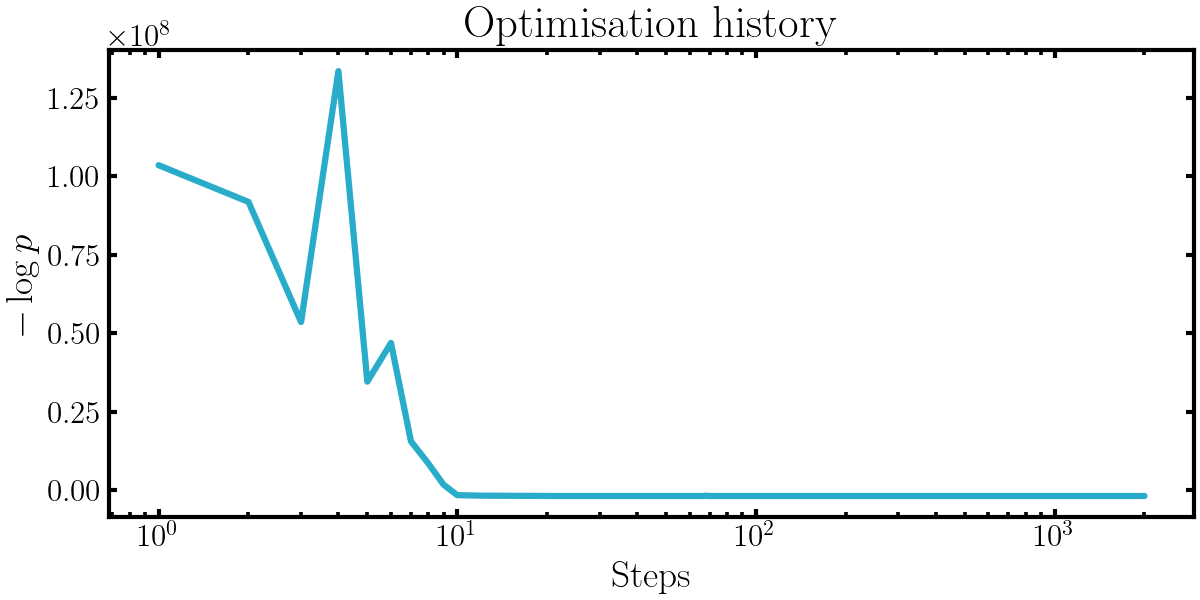

In [9]:
fig, ax = plt.subplots(figsize=[8, 4], layout="compressed", dpi=150)
ax.set_xlabel("Steps")
ax.set_ylabel(r"$-\log{p}$")
ax.plot(np.arange(1, len(loss_history) + 1), loss_history)
ax.set_title("Optimisation history")
ax.set_xscale("log")
# plt.ylim(-1e7, 1.5e8)
plt.show()

## Model predictions

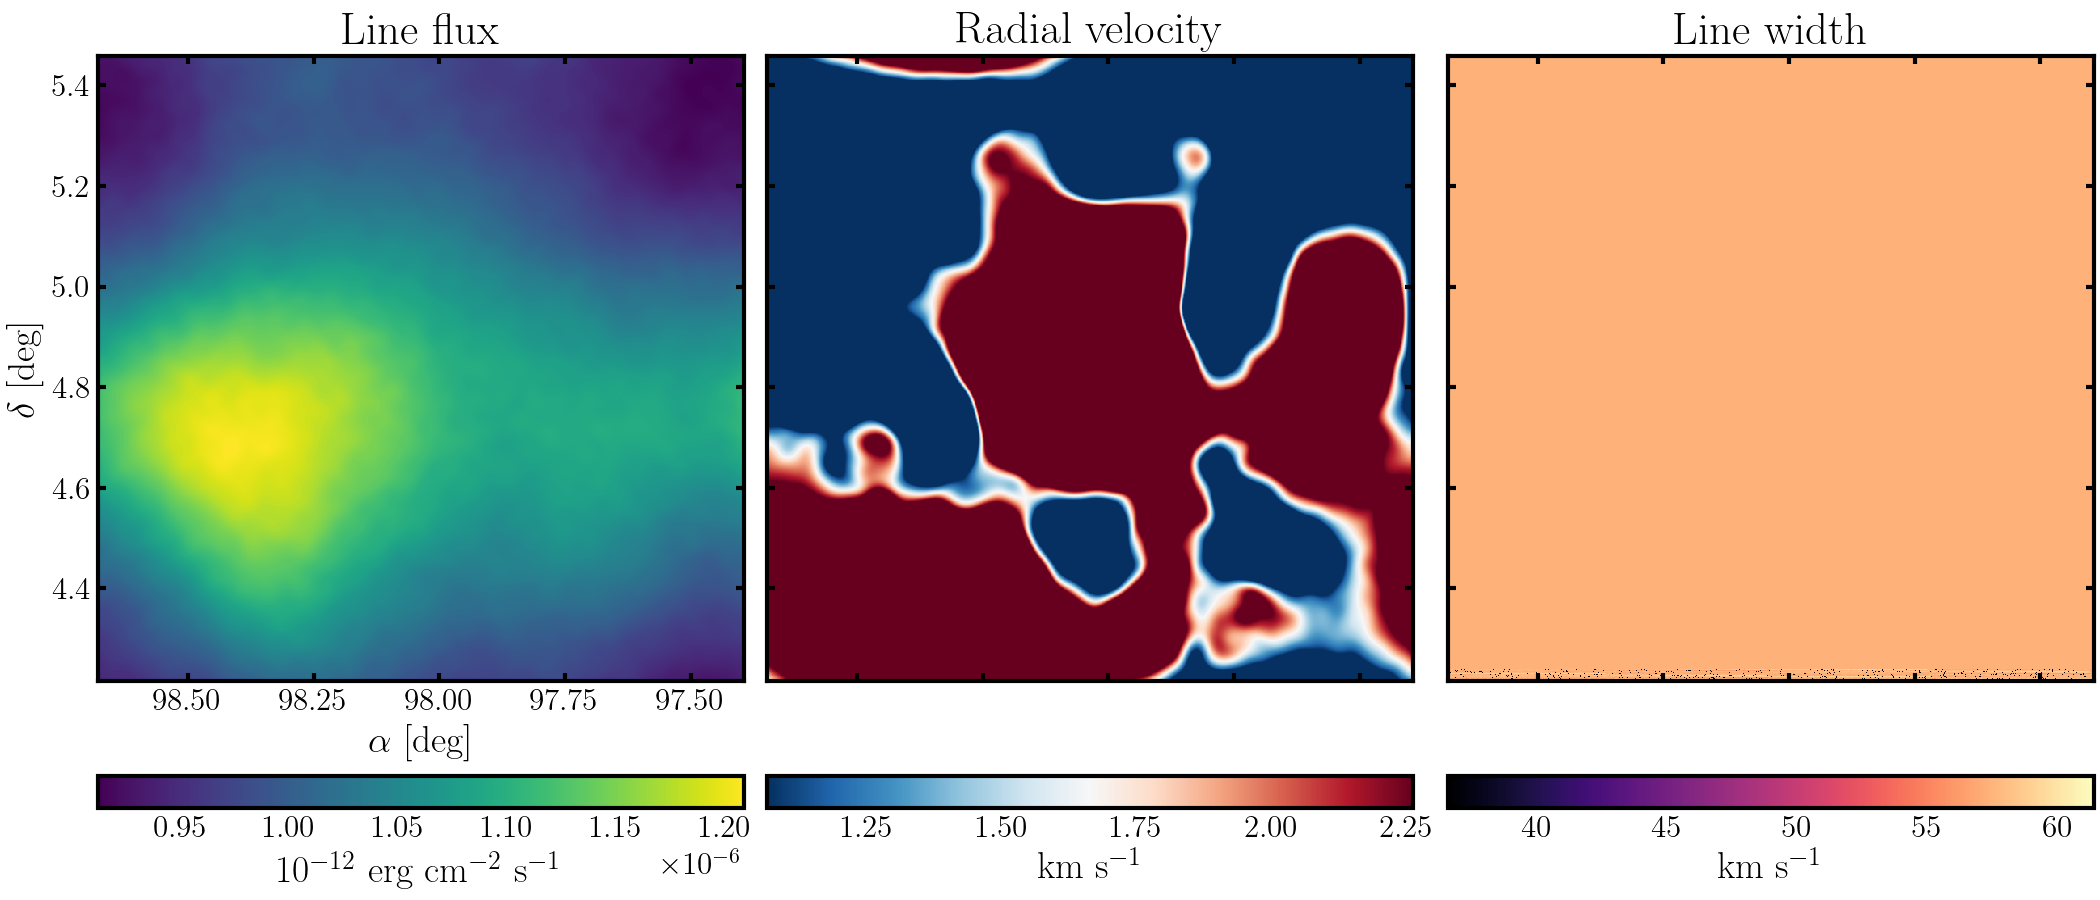

In [10]:
n_dense = 800
α_dense_1D = np.linspace(fd.α.min(), fd.α.max(), n_dense)
δ_dense_1D = np.linspace(fd.δ.min(), fd.δ.max(), n_dense)

α_dense, δ_dense = np.meshgrid(α_dense_1D, δ_dense_1D)
# SpatialData is just a convenience object for some of the jax stuff
αδ_dense = SpatialData(
    α_dense.flatten(),
    δ_dense.flatten(),
    indices=np.arange(n_dense**2, dtype=int),
)

# Predict the model on a dense grid ("positive" gives us the model subject to the positivity constraints on A and σ)
A_pred = pred_model.line.A_positive(αδ_dense).reshape((n_dense, n_dense))
λ0_pred = pred_model.line.λ0(αδ_dense).reshape((n_dense, n_dense))
σ_pred = pred_model.line.σ_positive(αδ_dense).reshape((n_dense, n_dense))

# Convert things to original/useful units
α_plot = fd.predict_α(α_dense)
δ_plot = fd.predict_δ(δ_dense)
A_plot = fd.predict_flux(A_pred)
λ0_plot = (np.array(λ0_pred / LINE_CENTRE) * constants.c).to(u.km / u.s).value
σ_plot = (np.array(σ_pred / LINE_CENTRE) * constants.c).to(u.km / u.s).value

fig, ax = plt.subplots(1, 3, figsize=[14, 6], layout="compressed", dpi=150)

# Line flux
ax[0].set_title("Line flux")
c0 = ax[0].pcolormesh(α_plot, δ_plot, A_plot / 1e-12, cmap="viridis")
ax[1].set_title(r"Radial velocity")
c1 = ax[1].pcolormesh(
    α_plot,
    δ_plot,
    λ0_plot,
    cmap="RdBu_r",
    vmin=np.median(λ0_plot) - 0.6,
    vmax=np.median(λ0_plot) + 0.6,
)
ax[2].set_title(r"Line width")
c2 = ax[2].pcolormesh(
    α_plot,
    δ_plot,
    σ_plot,
    cmap="magma",
    vmin=σ_plot.min(),
    vmax=np.median(σ_plot) + 4,
)

for i, a in enumerate(ax.flatten()):
    a.set_aspect(1)
    a.set_xlim(α_plot.max(), α_plot.min())
    a.set_axisbelow(False)
    if i != 0:
        a.set_xticklabels([])
        a.set_yticklabels([])

ax[0].set_xlabel(r"$\alpha$ [deg]")
ax[0].set_ylabel(r"$\delta$ [deg]")

colorbar_kwargs = dict(location="bottom", pad=0.02)
plt.colorbar(c0, ax=ax[0], **colorbar_kwargs, label=r"$10^{-12}$ erg cm$^{-2}$ s$^{-1}$")
plt.colorbar(c1, ax=ax[1], **colorbar_kwargs, label=r"km s$^{-1}$")
plt.colorbar(c2, ax=ax[2], **colorbar_kwargs, label=r"km s$^{-1}$")

plt.show()

Nice! The line flux looks great.

The RV and line widths on the other hand have basically fit a constant value to regions where the line flux is non-zero, and whatever outside that region where they are unconstrained.

I suspect we could do a bit better than this with some model reparameterisation and additional inclusions. As mentioned, we're completely neglecting any barycentric correction or accounting for LSF variations right now. I think that in this low S/N regime we really need those to actually find any real signal in RV and line widths.

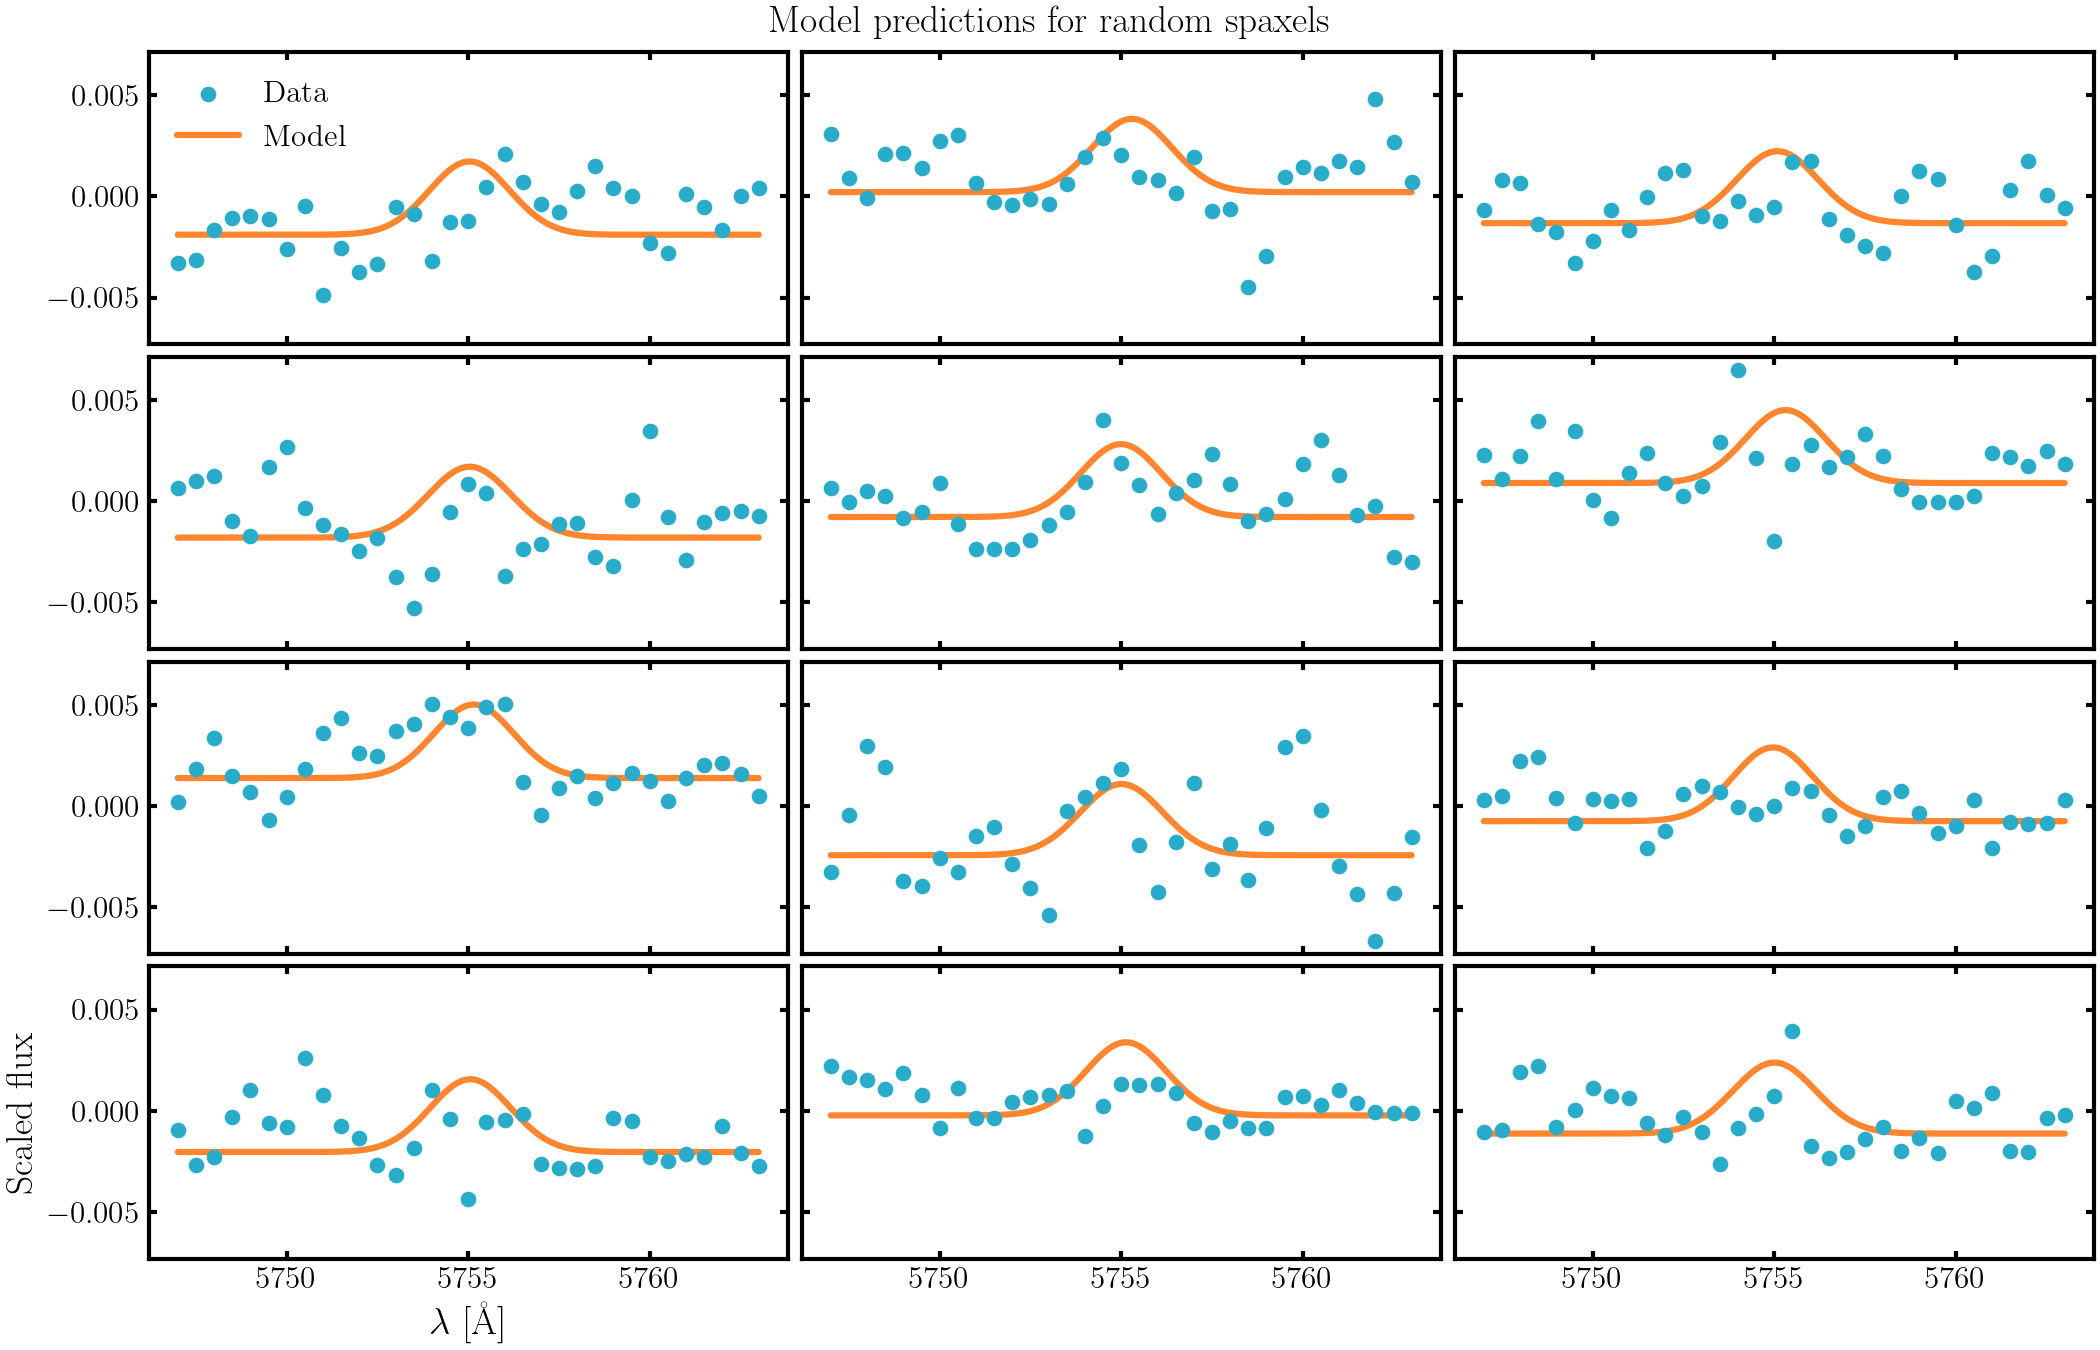

In [11]:
λ_dense = np.linspace(fd.λ.min(), fd.λ.max(), n_dense) - LINE_CENTRE
plot_λ = λ_dense + LINE_CENTRE

# We need to use vmap to vectorise over the wavelengths
pred_flux = jax.vmap(pred_model, in_axes=(0, None))(λ_dense, fd.αδ_data)
pred_flux = fd.predict_flux(pred_flux)

fig, ax = plt.subplots(
    4, 3, figsize=[14, 9], layout="compressed", sharex=True, sharey=True, dpi=150
)

ax_flat = ax.flatten()

for i, j in enumerate(rng.choice(n_spaxels, 12, replace=False)):
    # Make model predictions for the j-th spaxel

    norm = 1e-12
    ax_flat[i].scatter(fd.λ, fd.predict_flux(fd._flux[:, j]) / norm, zorder=1, label="Data")
    ax_flat[i].plot(plot_λ, pred_flux[:, j] / norm, c=COLORS[1], zorder=0, label="Model")

ax[0, 0].legend(loc="upper left", frameon=False)

ax[-1, 0].set_xlabel(r"$\lambda$ [${\rm \AA}$]")
ax[-1, 0].set_ylabel(r"Scaled flux")

fig.suptitle("Model predictions for random spaxels")


plt.show()

We should also do residuals

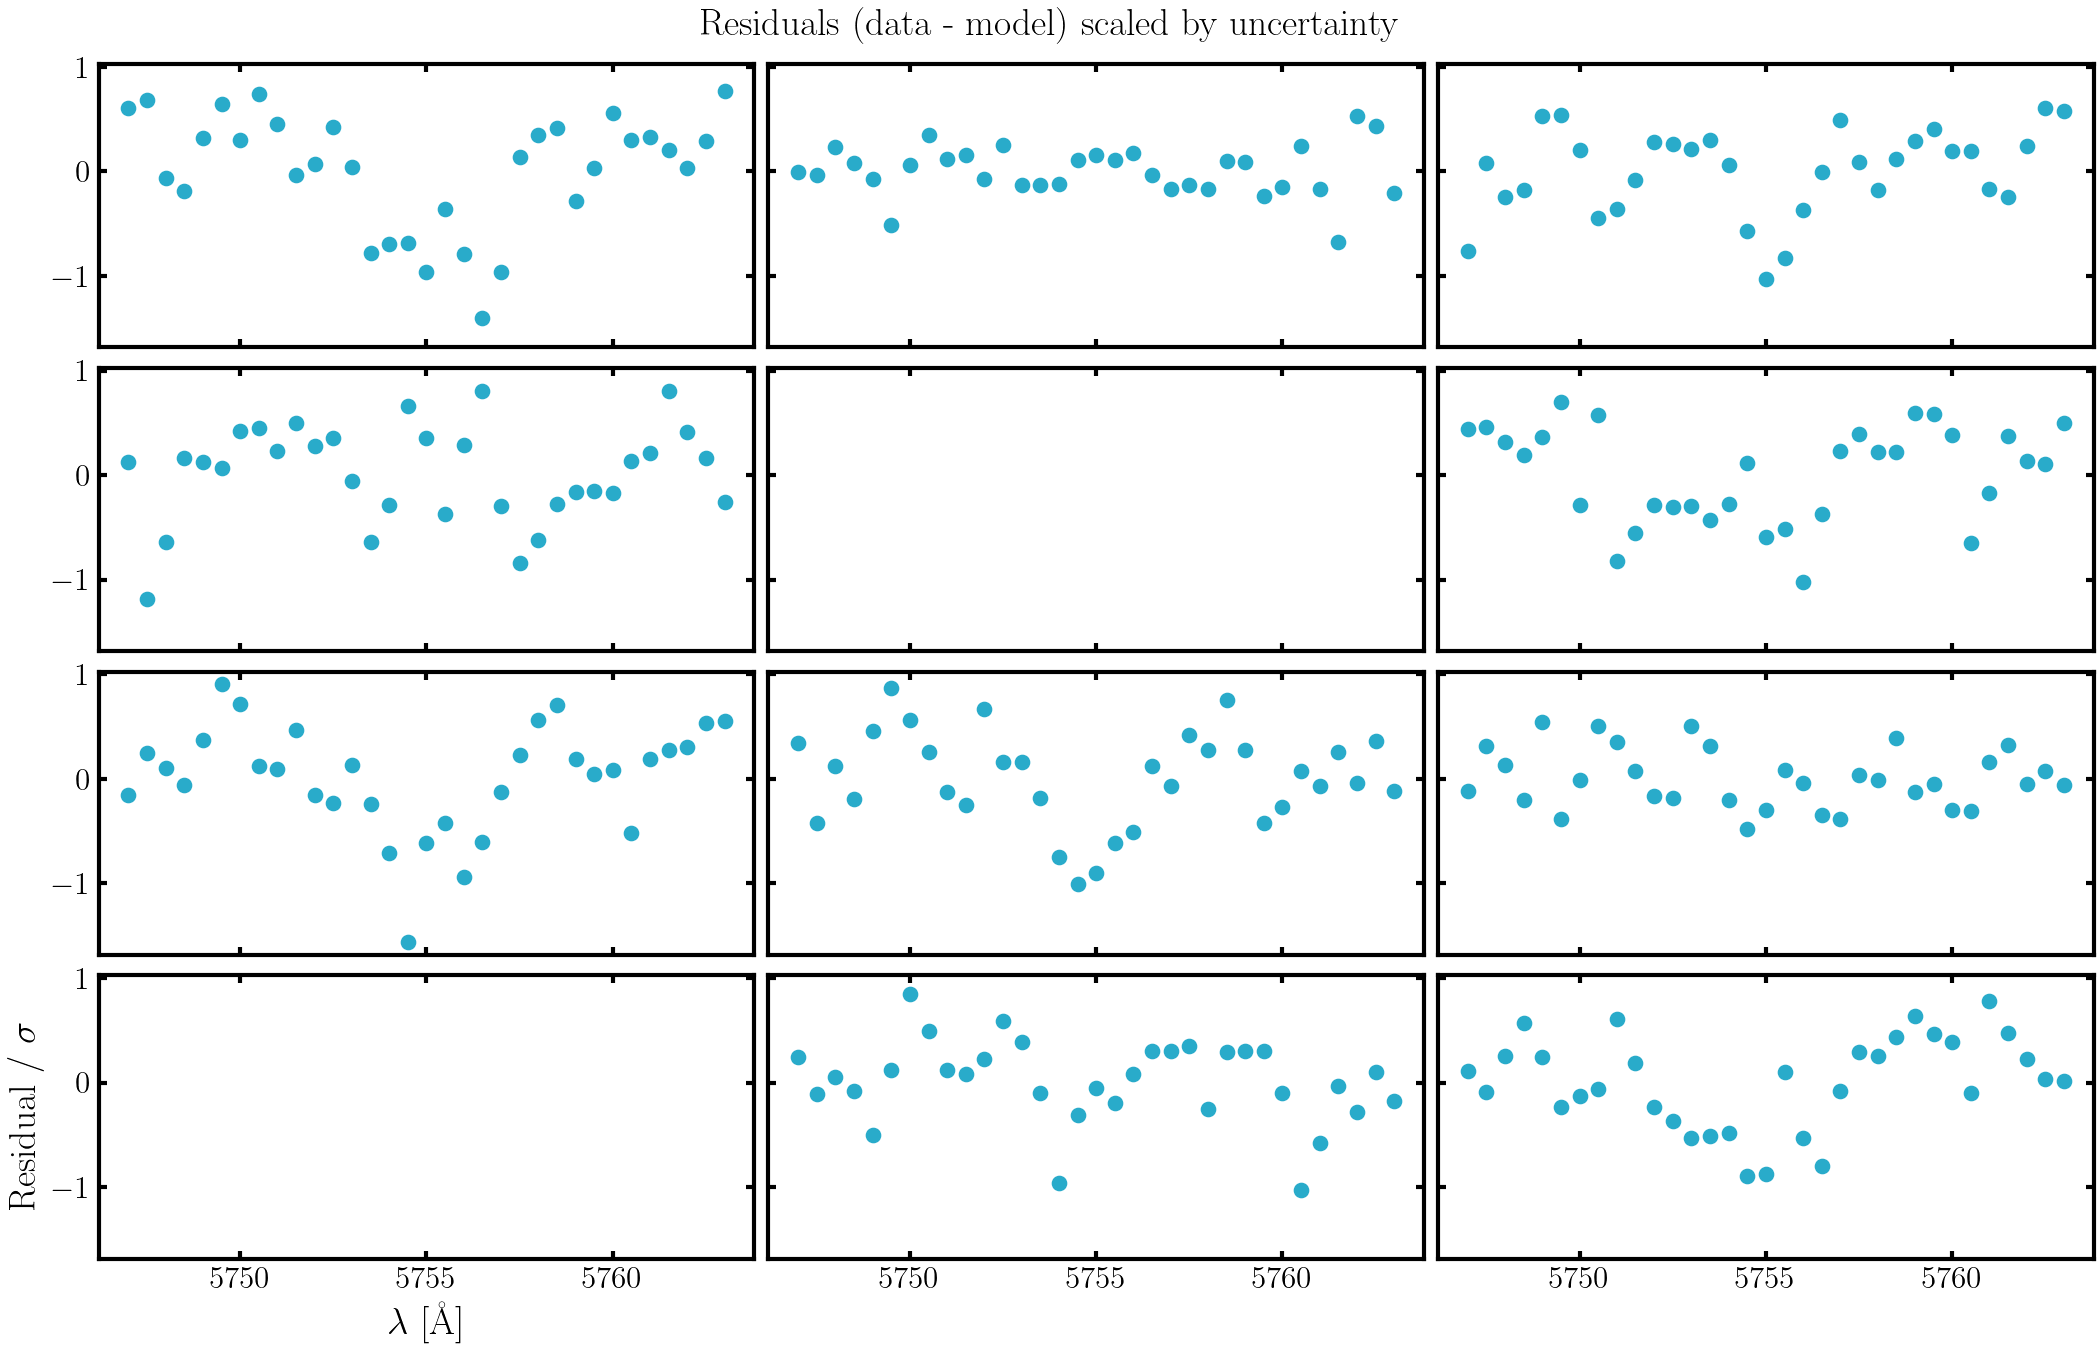

In [12]:
# We need to use vmap to vectorise over the wavelengths
pred_flux = jax.vmap(pred_model, in_axes=(0, None))(fd.λ - LINE_CENTRE, fd.αδ_data)
pred_flux = fd.predict_flux(pred_flux)

fig, ax = plt.subplots(
    4, 3, figsize=[14, 9], layout="compressed", sharex=True, sharey=True, dpi=150
)

ax_flat = ax.flatten()

for i, j in enumerate(rng.choice(n_spaxels, 12, replace=False)):
    ax_flat[i].scatter(
        fd.λ,
        (fd.predict_flux(fd._flux[:, j]) - pred_flux[:, j])
        * fd.predict_ivar(fd._i_var[:, j]) ** 0.5,
        zorder=1,
    )

ax[-1, 0].set_xlabel(r"$\lambda$ [${\rm \AA}$]")
ax[-1, 0].set_ylabel(r"Residual / $\sigma$")
fig.suptitle("Residuals (data - model) scaled by uncertainty")

plt.show()

I think these residuals look quite good.

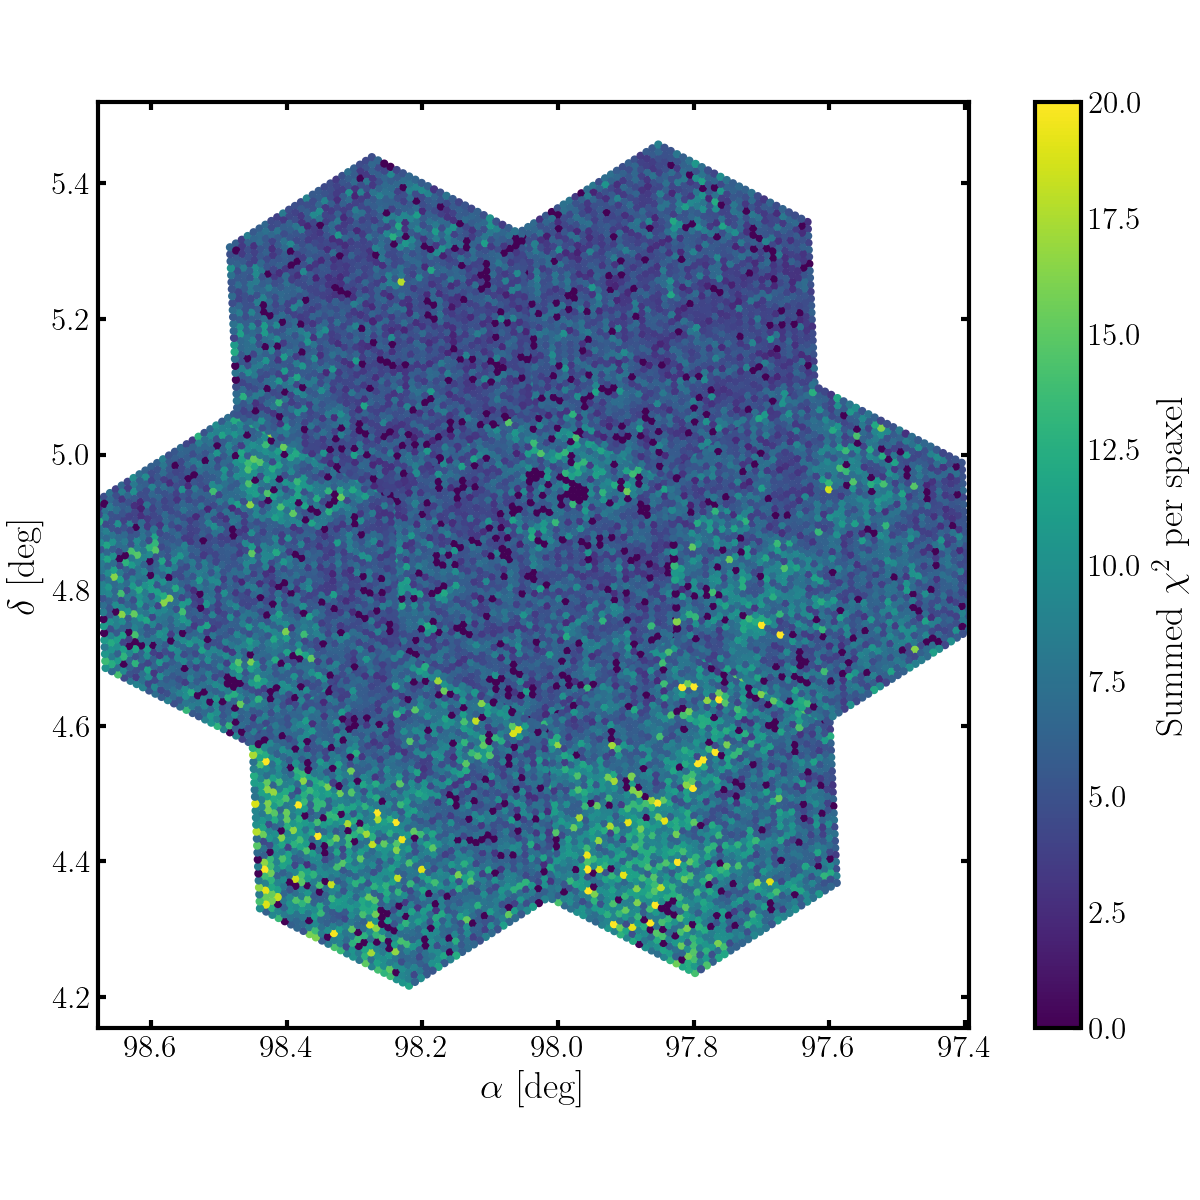

In [13]:
pred_flux = jax.vmap(pred_model, in_axes=(0, None))(fd.λ - LINE_CENTRE, fd.αδ_data)

χ2 = (fd.flux - pred_flux) ** 2 * fd.i_var

fig, ax = plt.subplots(figsize=[8, 8], layout="compressed", dpi=150)
cs = ax.scatter(fd.predict_α(fd.α), fd.predict_δ(fd.δ), c=np.sum(χ2, axis=0), s=6, vmin=0, vmax=20)
plt.colorbar(cs, ax=ax, label=r"Summed $\chi^2$ per spaxel")
ax.set_xlabel(r"$\alpha$ [deg]")
ax.set_ylabel(r"$\delta$ [deg]")
ax.set_xlim(fd.predict_α(fd.α).max(), fd.predict_α(fd.α).min())
ax.set_aspect(1)
plt.show()

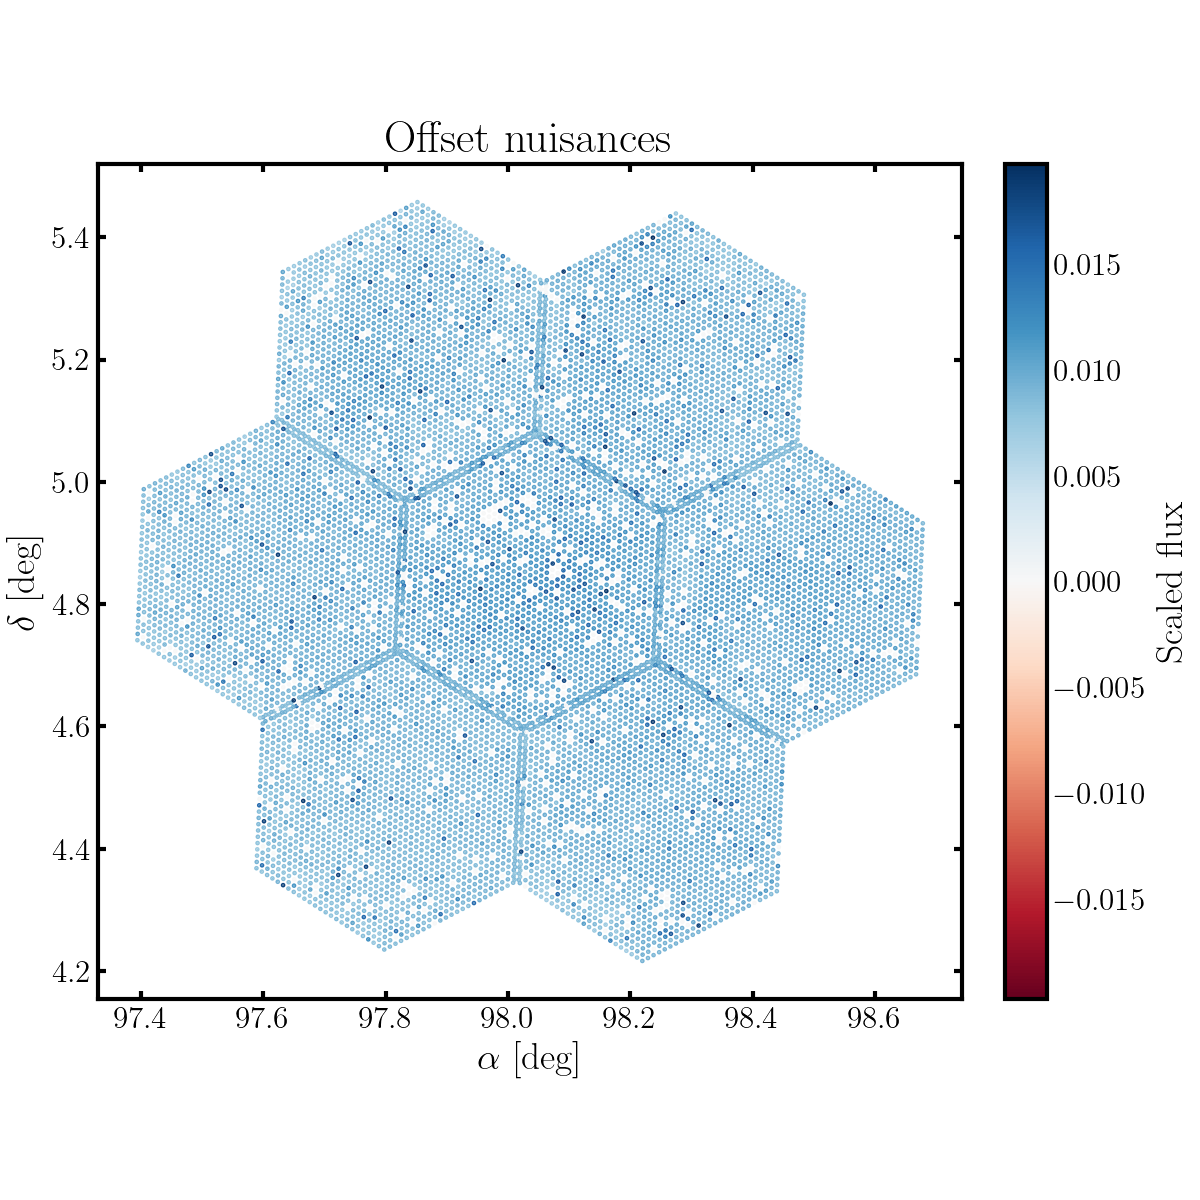

In [14]:
offsets = pred_model.continuum.const.spaxel_values.val

fig, ax = plt.subplots(figsize=[8, 8], layout="compressed", dpi=150)
ax.set_title("Offset nuisances")
cs = ax.scatter(
    fd.predict_α(fd.α),
    fd.predict_δ(fd.δ),
    c=offsets,
    s=0.5,
    vmin=-offsets.max(),
    vmax=offsets.max(),
    cmap="RdBu",
)
plt.colorbar(cs, ax=ax, label=r"Scaled flux")
ax.set_xlabel(r"$\alpha$ [deg]")
ax.set_ylabel(r"$\delta$ [deg]")
ax.set_aspect(1)
plt.show()